# 🩺 Stroke Prediction: End-to-End Machine Learning Pipeline

# 1. Import Libraries
Import all necessary libraries for data processing, modeling, and visualization

In [151]:
import sys
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.metrics import f1_score, classification_report,ConfusionMatrixDisplay, confusion_matrix,roc_auc_score,roc_curve, auc
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import StackingClassifier,RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
import shap
import joblib
import seaborn as sns
from ydata_profiling import ProfileReport
%matplotlib inline

In [102]:
# Configuration file for paths and constants
sys.path.append(os.path.abspath(".."))
from config import DATA_RAW_PATH, DATA_PREDICTED_PATH,DATA_PROCESSED_PATH, MODEL_DIR, TRAIN_FILE, TEST_FILE,TRAIN_PREPROCESSED_FILE,TEST_PREPROCESSED_FILE, SAMPLE_SUBMISSION_FILE, RANDOM_STATE,SCALING_FILE_NAME

In [103]:
import warnings
warnings.filterwarnings('ignore')

## 2. Dataset Meta Information

**Files:**
- `train.csv`: Data containing all available features and the stroke response.
- `test.csv`: Unseen stroke patients with all available predictors but missing stroke. Used for model prediction.
- `sample_submission.csv`: A sample submission file in the correct format.

**Data Dictionary:**
| Column            | Type     | Description                                                                                 | Values/Range                        |
|-------------------|----------|---------------------------------------------------------------------------------------------|-------------------------------------|
| `id`              | Integer  | Unique identifier for each record                                                            | Any integer                         |
| `gender`          | String   | Gender of the patient                                                                       | `Male`, `Female`                    |
| `age`             | Float    | Age of the patient in years                                                                 | Any positive float                  |
| `hypertension`    | Integer  | Indicates whether the patient has hypertension                                              | `0`: No, `1`: Yes                   |
| `heart_disease`   | Integer  | Indicates whether the patient has heart disease                                             | `0`: No, `1`: Yes                   |
| `ever_married`    | String   | Marital status of the patient                                                               | `Yes`, `No`                         |
| `work_type`       | String   | Type of employment                                                                          | `Private`, `Self-employed`, `Govt_job`, `Children`, etc. |
| `Residence_type`  | String   | Type of residence                                                                          | `Urban`, `Rural`                    |
| `avg_glucose_level`| Float   | Average glucose level of the patient (mg/dL)                                                | Any positive float                  |
| `bmi`             | Float    | Body Mass Index (BMI) of the patient                                                        | Any positive float                  |
| `smoking_status`  | String   | Smoking status                                                                             | `never smoked`, `formerly smoked`, `smokes`, `Unknown` |
| `stroke`          | Integer  | Target variable indicating whether the patient had a stroke (**[TARGET]**)                  | `0`: No, `1`: Yes                   |

# 3. Load Data
 Load training and test datasets

In [104]:
def read_data(base_path, file_name):
    """Reads a CSV file from the specified base path and returns a DataFrame."""
    try:
        df = pd.read_csv(f'{base_path}/{file_name}')
        return df
    except Exception as e:
        print(f"Error reading {file_name}: {e}")
        return pd.DataFrame()

In [105]:
def save_data(df, base_path, file_name):
    """Writes a DataFrame to a CSV file in the specified base path."""
    try:
        df.to_csv(f'{base_path}/{file_name}', index=False)
        print(f"Data written to {file_name} successfully.")
    except Exception as e:
        print(f"Error writing {file_name}: {e}")

In [106]:
# Load the training data
train = read_data(DATA_RAW_PATH, TRAIN_FILE)
# Load the test data
test = read_data(DATA_RAW_PATH, TEST_FILE)
# Load the sample submission file
sample_solution = read_data(DATA_RAW_PATH, SAMPLE_SUBMISSION_FILE)

# 4. Exploratory Data Analysis (EDA)

**4.1 Check dataset shape**

In [107]:
print("Train Data Shape:", train.shape)
print("Test Data Shape:", test.shape)

Train Data Shape: (12243, 12)
Test Data Shape: (3061, 11)


**4.2   Check dataset meta info**  

    Display data types and missing values

In [150]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12243 entries, 0 to 12242
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              12243 non-null  int64  
 1   age                             12243 non-null  float64
 2   hypertension                    12243 non-null  int64  
 3   heart_disease                   12243 non-null  int64  
 4   ever_married                    12243 non-null  int64  
 5   Residence_type                  12243 non-null  int64  
 6   avg_glucose_level               12243 non-null  float64
 7   bmi                             12243 non-null  float64
 8   stroke                          12243 non-null  float64
 9   gender_Male                     12243 non-null  bool   
 10  gender_Other                    12243 non-null  bool   
 11  work_type_Never_worked          12243 non-null  bool   
 12  work_type_Private               12243

**4.3 Statistical Summary**  

Show summary statistics for numerical features

In [148]:
train.describe(percentiles=[0.05,0.25, 0.5, 0.75,0,0.99])

,id,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke
count,12243.000000,12243.000000,12243.000000,12243.000000,12243.000000,12243.000000,12243.000000,12243.000000,12243.00000
mean,6122.000000,41.344951,0.049416,0.023279,0.675896,0.500204,88.820804,28.074400,0.04133
std,3534.394007,21.518463,0.216744,0.150793,0.468058,0.500020,24.957986,6.707892,0.19906
min,1.000000,0.080000,0.000000,0.000000,0.000000,0.000000,55.220000,10.300000,0.00000
0%,1.000000,0.080000,0.000000,0.000000,0.000000,0.000000,55.220000,10.300000,0.00000
5%,613.100000,4.000000,0.000000,0.000000,0.000000,0.000000,60.980000,17.900000,0.00000
25%,3061.500000,25.000000,0.000000,0.000000,0.000000,0.000000,74.880000,23.500000,0.00000
50%,6122.000000,43.000000,0.000000,0.000000,1.000000,1.000000,85.030000,27.600000,0.00000
75%,9182.500000,57.000000,0.000000,0.000000,1.000000,1.000000,96.840000,31.900000,0.00000
99%,12120.580000,81.000000,1.000000,1.000000,1.000000,1.000000,215.848800,46.900000,1.00000


**4.4 View Sample Data**  
Display the first few rows of the training data

In [110]:
train.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,Male,50.0,0,0,Yes,Private,Rural,88.10,29.1,formerly smoked,0
1,2,Female,52.0,0,0,Yes,Private,Rural,80.07,38.9,smokes,0
2,3,Female,26.0,0,0,No,Govt_job,Urban,89.11,23.3,smokes,0
3,4,Female,37.0,0,0,Yes,Private,Rural,81.36,36.1,never smoked,0
4,5,Male,59.0,0,0,Yes,Private,Rural,82.59,29.6,never smoked,1


**4.5 Check missing values**

Missing values in train data:
id                                0
age                               0
hypertension                      0
heart_disease                     0
ever_married                      0
Residence_type                    0
avg_glucose_level                 0
bmi                               0
stroke                            0
gender_Male                       0
gender_Other                      0
work_type_Never_worked            0
work_type_Private                 0
work_type_Self-employed           0
work_type_children                0
smoking_status_formerly smoked    0
smoking_status_never smoked       0
smoking_status_smokes             0
dtype: int64


Missing values in test data:
id                                0
age                               0
hypertension                      0
heart_disease                     0
ever_married                      0
Residence_type                    0
avg_glucose_level                 0
bmi                       

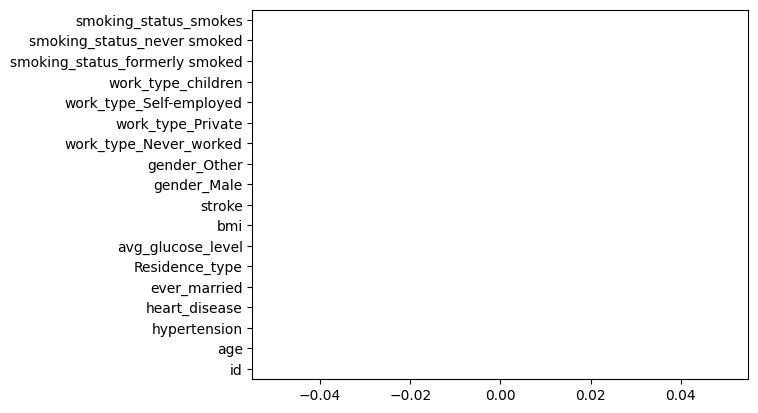

In [156]:
print("Missing values in train data:")
print(train.isnull().sum())
train.isna().sum().plot.barh()
print("\n")
print("Missing values in test data:")
print(test.isnull().sum())


**4.6 Data Profiling**  
 Generate an automated profiling report for EDA

In [112]:
profile = ProfileReport(train, title="Stroke Prediction Dataset Report", explorative=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:00<00:00, 129.10it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

**4.7 Target Variable Distribution**  
 Visualize the distribution of the target variable (stroke)

In [113]:
print("Stroke Value Counts:")
print(train['stroke'].value_counts())
print("\nStroke Percentage Distribution:")
print(train['stroke'].value_counts(normalize=True) * 100)

Stroke Value Counts:
stroke
0    11737
1      506
Name: count, dtype: int64

Stroke Percentage Distribution:
stroke
0    95.867026
1     4.132974
Name: proportion, dtype: float64


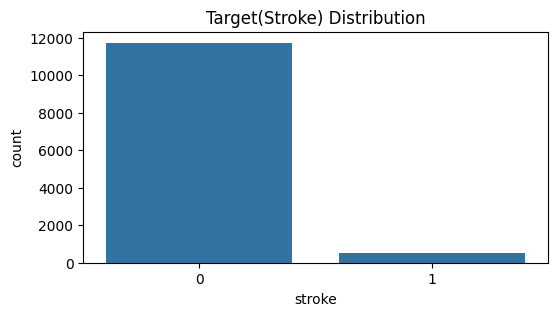

In [114]:
# Check class imbalance
plt.figure(figsize=(6, 3))
sns.countplot(x='stroke', data=train)
plt.title("Target(Stroke) Distribution")
plt.show()

<Axes: xlabel='age', ylabel='Count'>

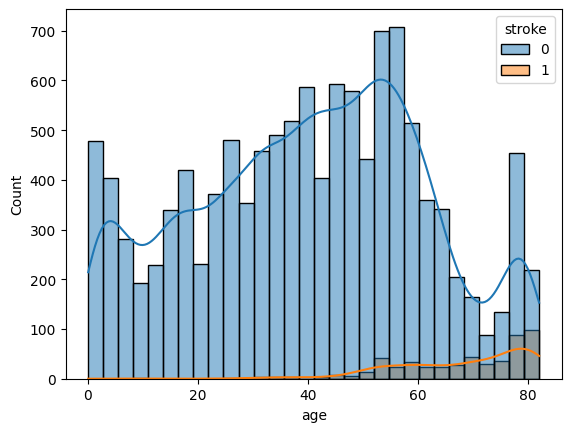

In [115]:
sns.histplot(data=train, x='age', hue='stroke', kde=True)

<Axes: xlabel='stroke', ylabel='avg_glucose_level'>

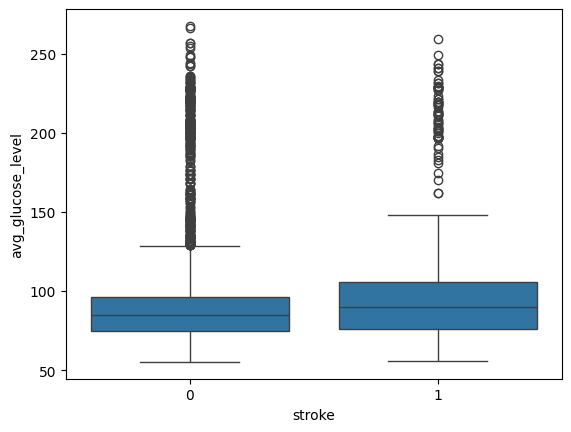

In [116]:
sns.boxplot(x='stroke', y='avg_glucose_level', data=train)

<Axes: xlabel='bmi', ylabel='Count'>

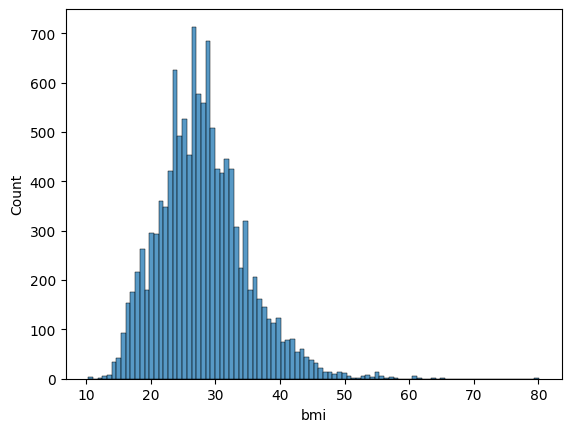

In [157]:
sns.histplot(data=train['bmi'])

***BMI is rightly skewed**

<Axes: ylabel='bmi'>

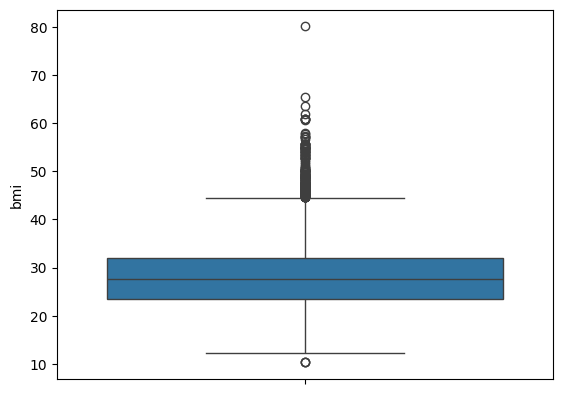

In [158]:
sns.boxplot(data=train['bmi'])

In [159]:
Q1 = train['bmi'].quantile(0.25)
Q3 = train['bmi'].quantile(0.75)
# Finding IQR
IQR = Q3 - Q1
da=(train['bmi'] < (Q1 - 1.5 * IQR)) | (train['bmi'] > (Q3 + 1.5 * IQR))
da.value_counts()

bmi
False    12033
True       210
Name: count, dtype: int64

***Total no of outliers 210**  
***Total no of non outliers 12033**

<Axes: xlabel='stroke', ylabel='bmi'>

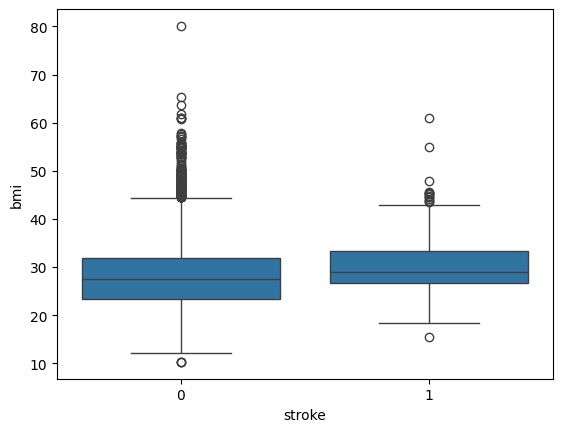

In [117]:
sns.boxplot(x='stroke', y='bmi', data=train)

***Based on the histogram and boxplot we see that there are many outliers in bmi**

# 6. Data Preprocessing
 

In [118]:
# Combine train and test data for preprocessing
train['is_train'] = 1
test['is_train'] = 0
test['stroke'] = np.nan
full_data = pd.concat([train, test], ignore_index=True)

In [119]:
# Display the first few rows of the combined data
full_data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,is_train
0,1,Male,50.0,0,0,Yes,Private,Rural,88.10,29.1,formerly smoked,0.0,1
1,2,Female,52.0,0,0,Yes,Private,Rural,80.07,38.9,smokes,0.0,1
2,3,Female,26.0,0,0,No,Govt_job,Urban,89.11,23.3,smokes,0.0,1
3,4,Female,37.0,0,0,Yes,Private,Rural,81.36,36.1,never smoked,0.0,1
4,5,Male,59.0,0,0,Yes,Private,Rural,82.59,29.6,never smoked,1.0,1


**Check distinct values in categorical variables**

In [120]:
# Check unique values in categorical columns
cat_cols = ['ever_married', 'Residence_type','gender', 'work_type', 'smoking_status']
for c in cat_cols:
    print(f"{c}: {full_data[c].unique()}" )

ever_married: ['Yes' 'No']
Residence_type: ['Rural' 'Urban']
gender: ['Male' 'Female' 'Other']
work_type: ['Private' 'Govt_job' 'children' 'Self-employed' 'Never_worked']
smoking_status: ['formerly smoked' 'smokes' 'never smoked' 'Unknown']


In [121]:
# Fill missing values in 'bmi' with the median and 'smoking_status' with 'Unknown'
full_data['bmi'] = full_data['bmi'].fillna(full_data['bmi'].median())
full_data['smoking_status'] = full_data['smoking_status'].fillna('Unknown')

# 7. Feature Engineering
**Encode categorical variables using One HOT Encodering**

**convert catagorical variables to binary format**

In [122]:
# Map binary categorical variables to numerical values
binary_map = {'Yes': 1, 'No': 0, 'Urban': 1, 'Rural': 0}
full_data['ever_married'] = full_data['ever_married'].map(binary_map)
full_data['Residence_type'] = full_data['Residence_type'].map(binary_map)

# One-hot encode categorical variables
full_data = pd.get_dummies(full_data, columns=['gender', 'work_type', 'smoking_status'], drop_first=True)

**Separate the training and test datasets**  
'is_train' column indicates whether the row is from the training set (1) or

In [123]:
# Split the combined data back into train and test sets
train = full_data[full_data['is_train'] == 1].drop(['is_train'], axis=1)
test = full_data[full_data['is_train'] == 0].drop(['is_train', 'stroke'], axis=1)

**Save the preprocessed data for future reference**

In [124]:
save_data(train, DATA_PROCESSED_PATH, TRAIN_PREPROCESSED_FILE)
save_data(test, DATA_PROCESSED_PATH, TEST_PREPROCESSED_FILE)

Data written to train_preprocessed.csv successfully.
Data written to test_preprocessed.csv successfully.


# 8. Feature Selection
**Select features for modeling (exclude 'id' and 'stroke')**

In [125]:
features = [col for col in train.columns if col not in ['id', 'stroke']]
X = train[features]
y = train['stroke'].astype(int)

In [126]:
X

,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,gender_Male,gender_Other,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,50.0,0,0,1,0,88.10,29.1,True,False,False,True,False,False,True,False,False
1,52.0,0,0,1,0,80.07,38.9,False,False,False,True,False,False,False,False,True
2,26.0,0,0,0,1,89.11,23.3,False,False,False,False,False,False,False,False,True
3,37.0,0,0,1,0,81.36,36.1,False,False,False,True,False,False,False,True,False
4,59.0,0,0,1,0,82.59,29.6,True,False,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12238,32.0,0,0,1,1,85.00,25.8,False,False,False,True,False,False,False,False,False
12239,31.0,0,0,1,1,92.00,30.1,False,False,False,False,False,False,False,False,False
12240,65.0,0,0,1,0,91.44,30.9,True,False,False,True,False,False,False,False,False
12241,75.0,0,0,1,1,73.02,30.1,False,False,False,True,False,False,True,False,False


In [127]:
y

0        0
1        0
2        0
3        0
4        1
        ..
12238    0
12239    0
12240    0
12241    0
12242    0
Name: stroke, Length: 12243, dtype: int64

# 9. Handle Class Imbalance
**Apply SMOTE to balance the target classes**

In [128]:
smote = SMOTE(random_state=RANDOM_STATE)
X_resampled, y_resampled = smote.fit_resample(X, y)

# 9.1. Visualize Resampled Distribution
**Plot the distribution after SMOTE resampling**

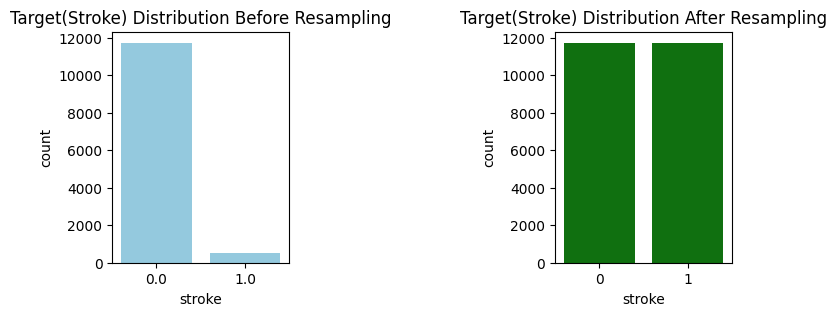

In [129]:
plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
sns.countplot(x='stroke', data=train,color='skyblue')
plt.title("Target(Stroke) Distribution Before Resampling")


plt.subplot(1, 2, 2)
sns.countplot(x=y_resampled,color='green')
plt.title("Target(Stroke) Distribution After Resampling")
plt.subplots_adjust(wspace=1.5)
plt.show()

# 13. Model Training Functions
**Define reusable functions for model training and evaluation**

**13.1 Feature scaling function**

In [ ]:
def scale_features(X_train, X_val, X_test=None):
    """
    Scales features using StandardScaler. Returns scaled train, val, and optionally test sets.
    """
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train[['bmi', 'avg_glucose_level', 'age']])
    X_val_scaled = scaler.transform(X_val[['bmi', 'avg_glucose_level', 'age']])
    if X_test is not None:
        X_test_scaled = scaler.transform(X_test)
        return X_train_scaled, X_val_scaled, X_test_scaled
    save_pickle_file(scaler, SCALING_FILE_NAME,MODEL_DIR)
    return X_train_scaled, X_val_scaled

**13.2 Model training function**

In [131]:
def train_model(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model

**13.3 ROC AUC plot function**

In [132]:
def roc_auc_plot(y_true, y_scores):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='blue', label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()
    print("ROC AUC Score:", roc_auc)

**13.4 Model Evaluation function**

In [133]:
def evaluate_model(model, X_val, y_val,model_name):
    y_pred = model.predict(X_val)
    print(f"Model: {model_name}")
    f1 = f1_score(y_val, y_pred)
    print("F1 Score:", f1_score(y_val, y_pred))
    report = classification_report(y_val, y_pred)
    print("Classification Report:\n", classification_report(y_val, y_pred))
    cm = confusion_matrix(y_val, y_pred)
    # sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()
    roc_auc_plot(y_val, model.predict_proba(X_val)[:, 1])
    return model

**13.5 Tune model function**

In [134]:
def tune_model(model,X_train,y_train,X_val,y_val, param_grid, name):
    print(f"--- Tuning {name} ---")
    grid = GridSearchCV(model, param_grid, cv=5, scoring='f1', verbose=1, n_jobs=-1)
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_val)
    
    print(f"Best Params for {name}: {grid.best_params_}")
    print("F1 Score:", f1_score(y_val, y_pred))
    print("Classification Report:\n", classification_report(y_val, y_pred))
    sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} Confusion Matrix")
    plt.show()
    roc_auc_plot(y_val, model.predict_proba(X_val)[:, 1])
    return best_model

**13.6 Define model and params tunning**

In [152]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_STATE),
    "LightGBM": lgb.LGBMClassifier(random_state=RANDOM_STATE),
    "Naive Bayes": GaussianNB()
}

logreg_params = {
    'C': [0.1, 1, 10],
    'solver': ['lbfgs'],
    'max_iter': [1000]
}
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

lgbm_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, -1],
    'learning_rate': [0.01, 0.1]
}
naive_params = {'var_smoothing': np.logspace(-12, -6, 7)}

**13.7 Final data save function**

In [136]:
def save_final_predictions(model, test,features, model_name,predicated_data_path=DATA_PREDICTED_PATH):
    """
    Generate predictions on the test set and save the submission file.
    """
    predictions = model.predict(test[features])
    prob=model.predict_proba(test[features])[0][1]
    submission = pd.DataFrame({
        'id': test['id'],
        'stroke': predictions,
        'probability': prob
    })
    submission.to_csv(f'{predicated_data_path}/submission_{model_name}.csv', index=False)
    print(f"Submission file saved as 'submission_{model_name}.csv'")

**13.8 Save model function**

In [137]:
def save_pickle_file(model, model_name,model_dir=MODEL_DIR):
    joblib.dump(model, f'{model_dir}/{model_name}.pkl')
    print(f"Pickle File saved as {model_name}.pkl")

# 12. Train/Validation Split
**Split the resampled data into training and validation sets**

In [138]:
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=RANDOM_STATE)

In [139]:
# Scale features before training models
X_train_scaled, X_val_scaled = scale_features(X_train, X_val)

Pickle File saved as scaler.pkl


# 14. Train and Evaluate model

**14.1 Model train and evaluate**

Model: Logistic Regression
F1 Score: 0.8807961041710777
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.89      0.88      2307
           1       0.89      0.87      0.88      2388

    accuracy                           0.88      4695
   macro avg       0.88      0.88      0.88      4695
weighted avg       0.88      0.88      0.88      4695



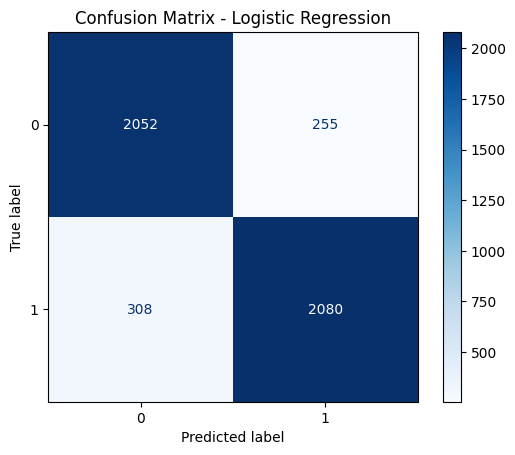

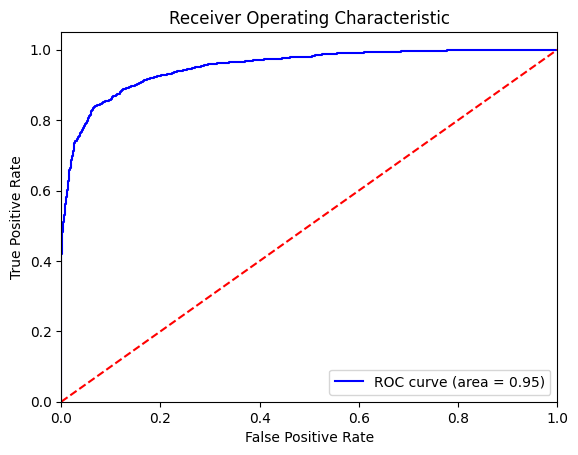

ROC AUC Score: 0.9517545101609769
Model: Random Forest
F1 Score: 0.9688349717632294
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      2307
           1       0.97      0.97      0.97      2388

    accuracy                           0.97      4695
   macro avg       0.97      0.97      0.97      4695
weighted avg       0.97      0.97      0.97      4695



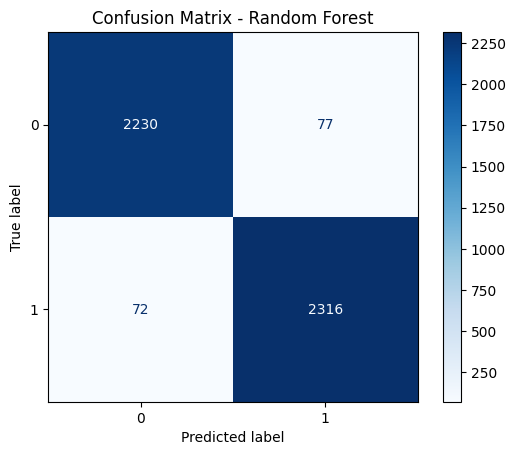

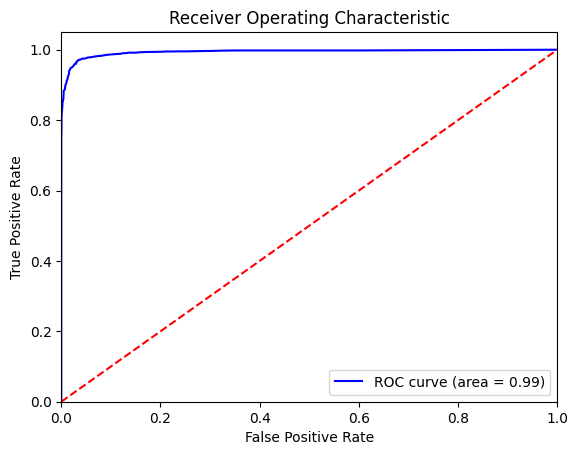

ROC AUC Score: 0.9936771162560382
Model: XGBoost
F1 Score: 0.9589442815249267
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96      2307
           1       0.96      0.96      0.96      2388

    accuracy                           0.96      4695
   macro avg       0.96      0.96      0.96      4695
weighted avg       0.96      0.96      0.96      4695



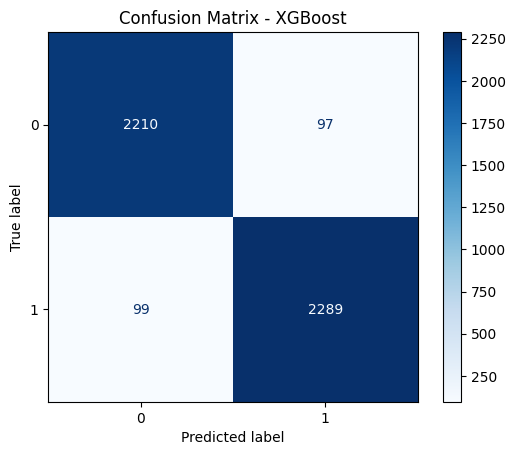

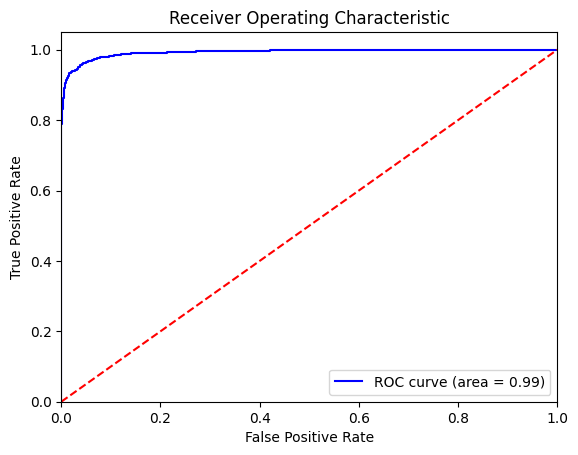

ROC AUC Score: 0.9928139106165129
[LightGBM] [Info] Number of positive: 9349, number of negative: 9430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 801
[LightGBM] [Info] Number of data points in the train set: 18779, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497843 -> initscore=-0.008627
[LightGBM] [Info] Start training from score -0.008627
Model: LightGBM
F1 Score: 0.9556299706990372
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95      2307
           1       0.96      0.96      0.96      2388

    accuracy                           0.95      4695
   macro avg       0.95      0.95      0.95      4695
weighted avg       0.95      0.95      0.95      4695



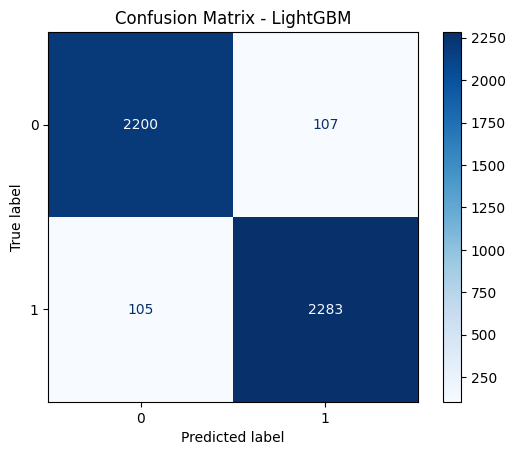

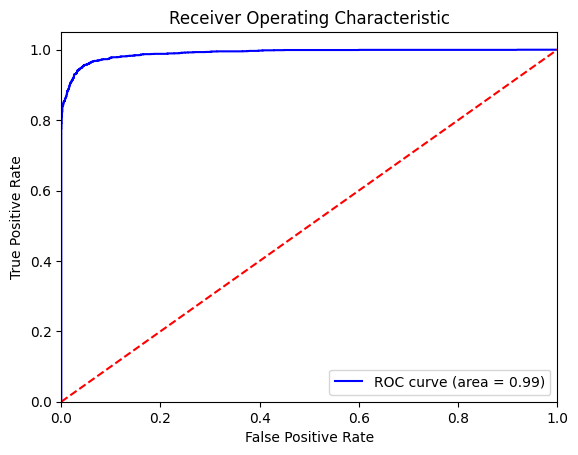

ROC AUC Score: 0.9907103063358985


In [140]:
trained_models = {}
for model_name, model in models.items():
    # # Train the model
    # model = train_model(model, X_train, y_train)
    # # Evaluate the model
    # trained_models[model_name] = evaluate_model(model, X_val, y_val,model_name)
    # Train the model
    model = train_model(model, X_train_scaled, y_train)
    # Evaluate the model
    trained_models[model_name] = evaluate_model(model, X_val_scaled, y_val,model_name)

**14.2 Cross-Validation Scores**

In [ ]:
print("\nCross-Validation Scores (F1):")
cv = StratifiedKFold(n_splits=20, shuffle=True, random_state=RANDOM_STATE)
for name, model in models.items():
    scores = cross_val_score(model, X_resampled, y_resampled, scoring='f1', cv=cv)
    print(f"{name}: Mean F1 = {scores.mean():.4f} | Std = {scores.std():.4f}")


Cross-Validation Scores (F1):
Logistic Regression: Mean F1 = 0.8830 | Std = 0.0052
Random Forest: Mean F1 = 0.9673 | Std = 0.0022
XGBoost: Mean F1 = 0.9601 | Std = 0.0022
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 9390, number of negative: 9389
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001693 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 789
[LightGBM] [Info] Number of data points in the train set: 18779, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500027 -> initscore=0.000107
[LightGBM] [Info] Start training from score 0.000107
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 9390, number of negative: 9389
[LightGBM] [Info] Auto-choosing row-wise multi

**14.3 Tune model and find best model params**

--- Tuning Logistic Regression ---
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Params for Logistic Regression: {'C': 10, 'max_iter': 1000, 'solver': 'lbfgs'}
F1 Score: 0.8810330228619814
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.89      0.88      2307
           1       0.89      0.87      0.88      2388

    accuracy                           0.88      4695
   macro avg       0.88      0.88      0.88      4695
weighted avg       0.88      0.88      0.88      4695



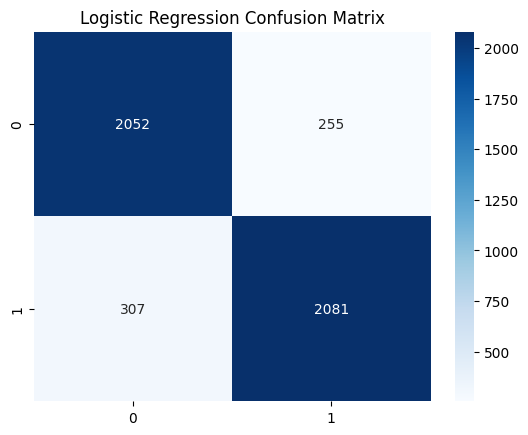

NotFittedError: This LogisticRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [153]:
best_logreg = tune_model(models["Logistic Regression"],X_train_scaled,y_train,X_val_scaled,y_val, logreg_params, "Logistic Regression")
best_rf = tune_model(models["Random Forest"],X_train_scaled,y_train,X_val_scaled,y_val, rf_params, "Random Forest")
best_xgb = tune_model(models["XGBoost"],X_train_scaled,y_train,X_val_scaled,y_val, xgb_params, "XGBoost")
best_lgbm = tune_model(models["LightGBM"],X_train_scaled,y_train,X_val_scaled,y_val, lgbm_params, "LightGBM")
best_naive_bayes = tune_model(models["Naive Bayes"],X_train_scaled,y_train,X_val_scaled,y_val, naive_params, "Naive Bayes")

**14.4 use stacking classsifier on best model parameters**

In [ ]:
estimators = [
    ('lr', best_logreg),
    ('rf', best_rf),
    ('xgb', best_xgb),
    ('lgbm', best_lgbm)
    
]

stack_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=1000),
    cv=5,
    n_jobs=-1,
    passthrough=False
)

Model: stacking
F1 Score: 0.9743481917577796
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97      2307
           1       0.98      0.97      0.97      2388

    accuracy                           0.97      4695
   macro avg       0.97      0.97      0.97      4695
weighted avg       0.97      0.97      0.97      4695



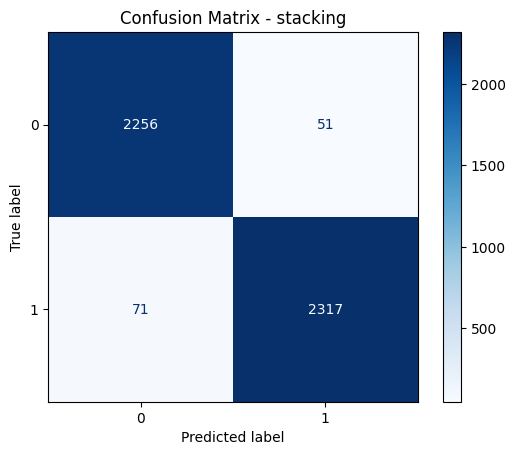

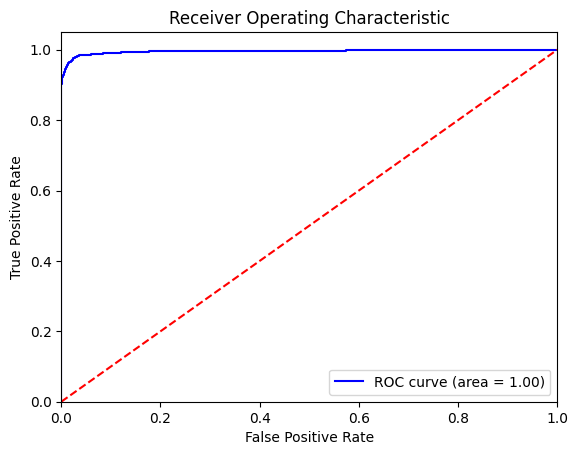

ROC AUC Score: 0.9954063410536282


In [144]:
stack_model = train_model(stack_model, X_train_scaled, y_train)
stacked_model_final = evaluate_model(stack_model,X_val_scaled,y_val, "stacking")

# 15. Save the predictions and models

In [ ]:
best_models = [
    (best_logreg, "logreg_model"),
    (best_rf, "rf_model"),
    (best_xgb, "xgb_model"),
    (best_lgbm, "lgbm_model"),
    (best_naive_bayes, "naive_bayes_model"),
    (stacked_model_final, "stacking_model")
]


for model, name in best_models:
    # Example SHAP usage for best model
    # explainer = shap.Explainer(model, X_train_scaled)
    # shap_values = explainer(X_val_scaled)
    # shap.summary_plot(shap_values, X_val_scaled, feature_names=features)

    save_final_predictions(model, test,features, name,DATA_PREDICTED_PATH)
    save_pickle_file(model, name)
    print(f"Model {name} saved and predictions generated.")

Submission file saved as 'submission_logreg_model.csv'
Pickle File saved as logreg_model.pkl
Model logreg_model saved and predictions generated.
Submission file saved as 'submission_rf_model.csv'
Pickle File saved as rf_model.pkl
Model rf_model saved and predictions generated.
Submission file saved as 'submission_xgb_model.csv'
Pickle File saved as xgb_model.pkl
Model xgb_model saved and predictions generated.
Submission file saved as 'submission_lgbm_model.csv'
Pickle File saved as lgbm_model.pkl
Model lgbm_model saved and predictions generated.
Submission file saved as 'submission_stacking_model.csv'
Pickle File saved as stacking_model.pkl
Model stacking_model saved and predictions generated.


# 16. Summarize and compare models

In [ ]:
model_scores = []
for model, name in best_models:
    y_pred = model.predict(X_val_scaled)
    y_proba = model.predict_proba(X_val_scaled)[:, 1] if hasattr(model, "predict_proba") else None
    f1 = f1_score(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_proba) if y_proba is not None else None
    model_scores.append({
        "Model": name,
        "F1 Score": f1,
        "ROC AUC": roc_auc
    })

score_df = pd.DataFrame(model_scores)
score_df = score_df.sort_values(by="F1 Score", ascending=False)
print(score_df)

            Model  F1 Score   ROC AUC
4  stacking_model  0.974348  0.995406
2       xgb_model  0.973029  0.995817
1        rf_model  0.968443  0.994266
3      lgbm_model  0.964083  0.993782
0    logreg_model  0.881033  0.951751


In [147]:
xgb_loaded=joblib.load(f"{MODEL_DIR}/xgb_model.pkl")
prd=xgb_loaded.predict_proba(test[test["id"]==1][features])[0][1]
prd

np.float32(0.78882146)

## 17. 🏁 Model Comparison Summary & Conclusion

### Model Performance Table

| Model           | F1 Score | ROC AUC  |
|-----------------|----------|----------|
| Stacking        | 0.974    | 0.995    |
| XGBoost         | 0.973    | 0.996    |
| Random Forest   | 0.968    | 0.994    |
| LightGBM        | 0.964    | 0.994    |
| Logistic Reg.   | 0.881    | 0.952    |

### Summary

- **Stacking Classifier** achieved the highest F1 Score (0.974) and a very high ROC AUC (0.995), indicating excellent overall performance and generalization.
- **XGBoost** closely follows, with nearly identical F1 and slightly higher ROC AUC, showing strong predictive power.
- **Random Forest** and **LightGBM** also performed very well, with F1 Scores above 0.96 and ROC AUCs above 0.99, making them reliable choices.
- **Logistic Regression** lags behind the ensemble models, with a lower F1 Score (0.88) and ROC AUC (0.95), but still provides a reasonable baseline.

### 17.1 Conclusion

For stroke prediction, **ensemble models** (Stacking, XGBoost, Random Forest, LightGBM) significantly outperform Logistic Regression, both in terms of F1 Score and ROC AUC.  
The **Stacking Classifier** offers the best balance of precision and recall, making it the recommended model for deployment.  
Further improvements can be made by exploring advanced feature engineering, deeper hyperparameter tuning, and external validation.

## 18. Assumptions

- The data provided is representative of the real-world population and is free from major sampling biases.
- All features used are relevant and sufficient for predicting stroke risk; no important predictors are missing.
- The SMOTE technique for balancing classes does not introduce unrealistic synthetic samples.
- Feature encoding (LabelEncoder) is appropriate for the categorical variables and does not distort relationships.
- The train/validation split is random and stratified, ensuring fair evaluation.
- No data leakage occurs between training and validation/test sets.


## 19. Future Scope

- **Feature Engineering:** Explore additional features, interaction terms, or domain-specific transformations to improve model performance.
- **Hyperparameter Tuning:** Perform extensive hyperparameter optimization for all models using techniques like Grid Search or Bayesian Optimization.
- **Model Ensembling:** Combine multiple models (e.g., stacking, blending) to leverage their strengths and further boost accuracy.
- **Explainability:** Integrate advanced explainability tools (e.g., SHAP, LIME) for better model interpretation and trust.
- **External Validation:** Test the models on external or real-world datasets to assess generalizability.
- **Deployment:** Develop an end-to-end pipeline for real-time stroke risk prediction in clinical settings.
- **Data Augmentation:** Investigate advanced data augmentation or synthetic data generation methods for rare classes.
- **Temporal Analysis:** If time-series or longitudinal data is available, incorporate temporal patterns for improved prediction.